In [1]:
from foundry.util.runtime import setup
setup()
import jax
print("Devices:", jax.devices())

from image_diffusion.main import logger
logger.setLevel('INFO')

Devices: [CudaDevice(id=0)]


In [2]:
import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train
from foundry.core.dataclasses import dataclass

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console

import matplotlib.pyplot as plt
from typing import Sequence

In [3]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    plt.scatter(zs[:, 0], zs[:, 1], c=colors, **kwargs)

def map(f, batch_size=None):
    return lambda x: jax.lax.map(f, x, batch_size=batch_size)

In [4]:
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image_diffusion/mnist-ddpm:v8")
checkpoint_url = artifact.get_entry("checkpoint.zarr.zip").ref
import foundry.util.serialize
checkpoint = foundry.util.serialize.load(checkpoint_url)

[11:27:42] INFO     image_diffusion - Learning T-SNE embedding...
[11:28:08] INFO     image_diffusion - Fit T-SNE embedding


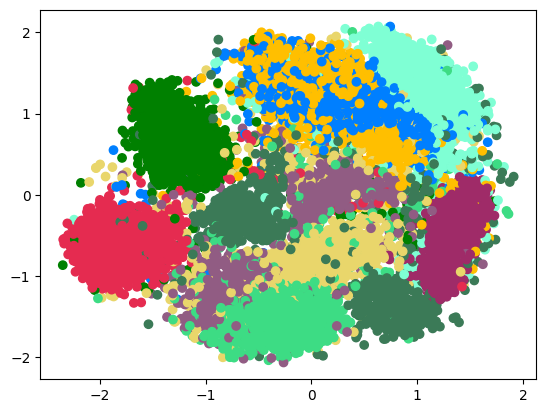

In [5]:
import jax
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())

latents = test_data.cond
embed_scatter(latents, test_data.label)

In [6]:
import foundry.diffusion.nonparametric as nonparametric
import functools

NUM_KEYPOINTS = 16
SAMPLES_PER_COND = 4
NW_SAMPLES_PER_COND = 32

COND_PER_DIM = 100

keypoints = train_data.cond[:NUM_KEYPOINTS]

sample_conds_xs = npx.linspace(npx.min(latents[:,0]) - 0.05, npx.max(latents[:,0]) + 0.05, COND_PER_DIM)
sample_conds_ys = npx.linspace(npx.min(latents[:,1]) - 0.05, npx.max(latents[:,1]) + 0.05, COND_PER_DIM)
sample_conds = npx.stack(npx.meshgrid(
    sample_conds_xs,
    sample_conds_ys
), -1)

@F.jit
def sample(N, vars, rng_key, cond):
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t - 1, cond=cond)
    sample = lambda rng_key: schedule.sample(rng_key, denoiser, npx.zeros(test_data.data[0].shape))
    return jax.lax.map(sample, foundry.random.split(rng_key, N))

@dataclass
class Evaluation:
    cond: jax.Array
    noised_y: jax.Array
    t: jax.Array
    out_model: jax.Array
    out_nw: jax.Array
    out_keypoints: jax.Array

@F.jit
def eval(vars, rng_key, cond):
    samples_rng, nw_rng, eval_rng = foundry.random.split(rng_key, 3)
    eval_samples = sample(SAMPLES_PER_COND, vars, samples_rng, cond)
    nw_samples = sample(NW_SAMPLES_PER_COND, vars, nw_rng, cond)
    def eval_sample(sample, rng_key):
        t = npx.array(schedule.num_steps // 2)
        noised_y, _, _ = schedule.add_noise(rng_key, sample, t)
        model_out = model.apply(vars, noised_y, t - 1, cond=cond)
        nw_out = schedule.output_from_denoised(
            noised_y, t,
            schedule.compute_denoised(noised_y, t, nw_samples)
        )
        out_keypoints = jax.lax.map(lambda k: model.apply(vars, noised_y, t-1, cond=k), keypoints)
        return Evaluation(
            cond=cond,
            noised_y=noised_y,
            t=t,
            out_model=model_out,
            out_nw=nw_out,
            out_keypoints=out_keypoints
        )
    return F.vmap(eval_sample)(eval_samples, foundry.random.split(eval_rng, SAMPLES_PER_COND))

sample_conds_flat = sample_conds.reshape((-1, 2))

batch_size = 32
eval_samples = []
rng = foundry.random.PRNGSequence(0)
for i in range(0, len(sample_conds_flat), batch_size):
    logger.info(f"Sampling at condition {i} of {len(sample_conds_flat)}")
    batch = sample_conds_flat[i:i+batch_size]
    samples = F.vmap(eval, in_axes=(None, 0, 0))(vars, foundry.random.split(next(rng), batch.shape[0]), batch)
    eval_samples.append(samples)

eval_samples_flat = tree.map(lambda *x: npx.concatenate(x, 0), *eval_samples)
# Free up memory
del eval_samples
eval_samples = tree.map(lambda x: x.reshape(sample_conds.shape[:2] + x.shape[1:]), eval_samples_flat)
del sample_conds_flat
del eval_samples_flat

[11:28:11] INFO     image_diffusion - Sampling at condition 0 of 10000
[11:28:29] INFO     image_diffusion - Sampling at condition 32 of 10000
[11:28:34] INFO     image_diffusion - Sampling at condition 64 of 10000
[11:28:39] INFO     image_diffusion - Sampling at condition 96 of 10000
[11:28:44] INFO     image_diffusion - Sampling at condition 128 of 10000
[11:28:49] INFO     image_diffusion - Sampling at condition 160 of 10000
[11:28:54] INFO     image_diffusion - Sampling at condition 192 of 10000
[11:28:59] INFO     image_diffusion - Sampling at condition 224 of 10000
[11:29:04] INFO     image_diffusion - Sampling at condition 256 of 10000
[11:29:09] INFO     image_diffusion - Sampling at condition 288 of 10000
[11:29:14] INFO     image_diffusion - Sampling at condition 320 of 10000
[11:29:19] INFO     image_diffusion - Sampling at condition 352 of 10000
[11:29:24] INFO     image_diffusion - Sampling at condition 384 of 10000
[11:29:29] INFO     image_diffusion - Sampling at condit

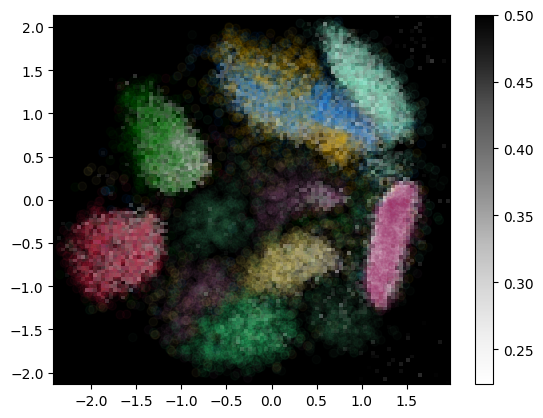

In [26]:
err = lambda val_a, val_b: npx.sqrt(npx.mean(npx.square(val_a - val_b)) )
eval_cond = lambda val_a, val_b: npx.mean(F.vmap(err)(val_a, val_b))
errs = F.vmap(F.vmap(eval_cond))(eval_samples.out_model, eval_samples.out_nw)

plt.pcolormesh(sample_conds_xs, sample_conds_ys, errs.clip(0,0.5), cmap="Greys")
plt.colorbar()
embed_scatter(latents, test_data.label, alpha=0.04)

In [10]:
import foundry.train
import foundry.train.console
import flax.linen as nn
from foundry.train import LossOutput
from foundry.data import PyTreeData

USE_SOFTMAX = True
USED_KEYPOINTS = 1
assert USED_KEYPOINTS <= keypoints.shape[0]

class KeypointModel(nn.Module):
    @nn.compact
    def __call__(self, cond, t):
        input = npx.concatenate([t[None], cond])
        logits = nn.Sequential([
            nn.Dense(64),
            nn.gelu,
            nn.Dense(64),
            nn.gelu,
            nn.Dense(64),
            nn.gelu,
            nn.Dense(USED_KEYPOINTS),
        ])(input)
        if USE_SOFTMAX:
            normalized = nn.softmax(logits, axis=-1)
        else:
            total = npx.sum(logits)
            normalized = logits + (1 - total)/logits.shape[0]
        return normalized

keypoint_model = KeypointModel()
keypoint_vars = keypoint_model.init(foundry.random.key(42),
    npx.zeros((2,)), npx.zeros((), dtype=npx.int32)
)
iterations = 10_000
optimizer = optax.adamw(optax.cosine_decay_schedule(4e-3, iterations))
opt_state = optimizer.init(keypoint_vars["params"])

@foundry.train.batch_loss
def loss_fn(keypoint_vars, rng_key, sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:USED_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    err = npx.mean(npx.square(interpolated - sample.out_model))
    return LossOutput(
        loss=err,
        metrics={"error": npx.sqrt(err)}
    )

with foundry.train.loop(
    PyTreeData(tree.map(lambda x: npx.reshape(x, (x.shape[0]*x.shape[1]*x.shape[2],) + x.shape[3:]), eval_samples)).stream().shuffle(foundry.random.key(42)).batch(128),
    iterations=iterations,
    rng_key=foundry.random.key(42)
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, keypoint_vars, metrics = foundry.train.step(
                loss_fn, optimizer, opt_state=opt_state,
                vars=keypoint_vars, rng_key=step.rng_key,
                batch=step.batch
            )
            if step.iteration % 100 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10000/10000 100% 0:00:00 0:00:25
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33/32       100% 0:00:00 0:00:25
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16       100% 0:00:00 0:00:00


[11:58:26] INFO     foundry.train -      0 | error: 0.2349315732717514
           INFO     foundry.train -    100 | error: 0.23444309830665588
           INFO     foundry.train -    200 | error: 0.23665326833724976
           INFO     foundry.train -    300 | error: 0.23469200730323792
[11:58:27] INFO     foundry.train -    400 | error: 0.23734086751937866
           INFO     foundry.train -    500 | error: 0.23690831661224365
           INFO     foundry.train -    600 | error: 0.23997068405151367
[11:58:28] INFO     foundry.train -    700 | error: 0.23529532551765442
           INFO     foundry.train -    800 | error: 0.2340523600578308
           INFO     foundry.train -    900 | error: 0.24202561378479004
           INFO     foundry.train -   1000 | error: 0.24825488030910492
[11:58:29] INFO     foundry.train -   1100 | error: 0.23526018857955933
           INFO     foundry.train -   1200 | error: 0.23617032170295715
           INFO     foundry.train -   1300 | error: 0.235142275691

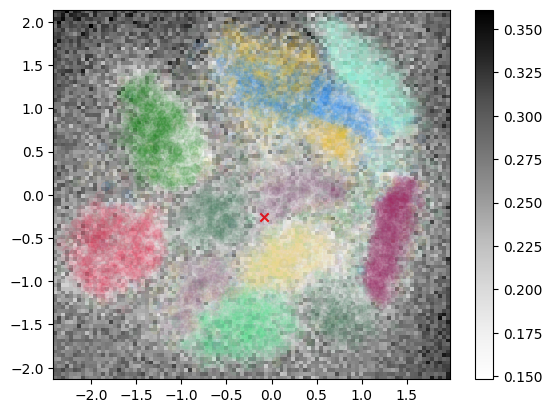

In [28]:
def eval(sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:USED_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    interpolated = sample.out_keypoints[0]
    err = npx.sqrt(npx.mean(npx.square(interpolated - sample.out_model)))
    return err

eval_cond = lambda samples: npx.mean(F.vmap(eval)(samples))
keypoint_errs = map(map(eval_cond, batch_size=4), batch_size=4)(eval_samples)

plt.pcolormesh(sample_conds_xs, sample_conds_ys, keypoint_errs, cmap="Greys")
plt.colorbar()
plt.scatter(keypoints[:USED_KEYPOINTS,0], keypoints[:USED_KEYPOINTS,1], c="red", marker="x")
embed_scatter(latents, test_data.label, alpha=0.04)